# Building Data Genome Project 2.0
## Weather sensitivity testing

Biam! (pic.biam@gmail.com)

In [1]:
# data and numbers
import numpy as np
import pandas as pd
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
%matplotlib inline

import scipy.stats as stats

In [2]:
path_raw = "..//data//meters//raw//"
path_weather = "..//data//weather//"
path_metadata = "..//data//metadata//"
path_cleaned = "..//data//meters//cleaned//"
path_anom = "..//data//meters//screening//anomalies//"

# Introduction

In this notebooks will be made visualizations showing the correlation between energy consumption and outside air temperature (weather sensitivity).<br>
Outliers in the raw meters dataset were detected using the [Seasonal Hybrid ESD (S-H-ESD)](https://github.com/twitter/AnomalyDetection) developed by Twitter. This was implemented in R language, the process can be found [here](https://github.com/buds-lab/building-data-genome-project-2/blob/master/notebooks/04_Anomaly-detection.html). The methodology used here is from _Forensically discovering simulation feedback knowledge from a campus energy information system_ [(Miller - Schlueter, 2015)](https://cargocollective.com/buildingdata/Forensic-Analysis-of-Campus-Dataset).<br>

# Functions

In [3]:
# This function removes outliers and 24 hours zero readings
def removeBadData(df, metername):

    # load anomalies df
    df_anom = pd.read_csv(path_anom + metername + "_anoms.csv")
    # Transform timestamp to datetime object type
    df_anom["timestamp"] = pd.to_datetime(
        df_anom["timestamp"], format="%Y-%m-%d %H:%M:%S"
    )
    # Remove timezone offset at the end of timestamp
    df_anom["timestamp"] = df_anom.timestamp.apply(lambda d: d.replace(tzinfo=None))
    # Set index
    df_anom = df_anom.set_index("timestamp")

    # Remove outliers
    outliers = df_anom.copy()
    # replace not null values with 9999 (outliers)
    outliers[outliers.isna() == False] = 9999
    # Update df with outliers data
    df.update(outliers)
    # Remove outliers
    for datapoint in df.columns:
        df[datapoint] = df[datapoint][df[datapoint] != 9999]

    # Remove zero gaps
    # Calculate daily average and aggregate data
    df_daily = df.resample("D").mean()
    # De-aggreate data asigning daily mean to each hour
    df_hourly = df_daily.resample("H").fillna(method="ffill")

    ## This dataset ends on 2017-12-31 00:00:00. Our meter dataset ends on 2017-12-31 23:00:00.##
    ## This is solved in the following code ##

    # Last row of df_hourly to copy values
    sample = df_hourly[df_hourly.index == "2017-12-31 00:00:00"]
    # Dataframe
    rng = pd.DataFrame(
        index=pd.date_range("2017-12-31 01:00:00", periods=23, freq="H"),
        columns=df.columns,
    )
    appdf = (
        sample.append(rng)
        .fillna(method="ffill")
        .drop(pd.Timestamp("2017-12-31 00:00:00"))
    )
    # Append
    df_hourly = df_hourly.append(appdf)

    # Delete zero values during whole day
    for datapoint in df_hourly.columns:
        df[datapoint] = df[datapoint][df_hourly[datapoint] > 0]

    del (df_anom, outliers, df_daily, df_hourly)

    return df

In [4]:
# This function merge meter data, weather and metadata
def mergeAll(metername, meter_df, weather_df, metadata_df):

    # Filters metadata with only current meter info
    df_meta = metadata_df.loc[
        meta[metername] == "Yes", ["building_id", "site_id"]
    ].copy()
    site_list = list(df_meta.site_id.unique())

    # Filters weather with only current sites
    df_weather = weather_df.loc[weather_df["site_id"].isin(site_list) == True,].copy()
    # Converts timestamp to datetime object
    df_weather["timestamp"] = pd.to_datetime(
        df_weather["timestamp"], format="%Y-%m-%d %H:%M:%S"
    )

    # Melt meter dataset
    meter_df = pd.melt(
        meter_df.reset_index(),
        id_vars="timestamp",
        var_name="building_id",
        value_name="meter_reading",
    )

    # Merge
    meter_df = pd.merge(meter_df, df_meta, how="left", on="building_id").merge(
        df_weather, how="left", on=["timestamp", "site_id"]
    )

    return meter_df

In [5]:
# Use this function to plot each meter individually
def plotHeatmap(df, metername):
    numberofplots = 1
    fig = plt.figure(figsize=(10,15))

    # Get the data
    x = mdates.drange(df.columns[0], df.columns[-1] + dt.timedelta(days=30), dt.timedelta(days=30))
    y = np.linspace(1, len(df), len(df)+1)

    # Plot
    ax = fig.add_subplot(numberofplots, 1, 1)
    data = np.array(df)
    cmap = plt.get_cmap('RdBu')
    qmesh = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=True, vmin=-1, vmax=1)
    
    # Colorbar
    cbaxes = fig.add_axes([0.13, 0.1, 0.77, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax = cbaxes)
    cbar.set_label('Spearman Rank Coefficient')
    ax.axis('tight')

    # Set up as dates
    ax.xaxis_date()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)

    # Axis
    ax.set_xlabel("Timeline", fontsize=16)
    ax.set_ylabel("", fontsize=16)
    ax.set_title(str(metername) +" Weather Sensitivity Screening", fontdict={'fontsize':20},
)
    #plt.tight_layout()
    plt.subplots_adjust(bottom=0.17)

    return fig

In [6]:
# This function process meter data automatically
def processData(metername):
    # load data
    df = pd.read_csv(path_raw + metername + ".csv") 
    # Transform timestamp to datetime object type
    df["timestamp"] = pd.to_datetime(df["timestamp"], format='%Y-%m-%d %H:%M:%S')
    # Set index
    df = df.set_index("timestamp")
    
    # Remove bad data
    df_clean = removeBadData(df, metername)
    
    # Merge datasets
    df_clean = mergeAll(metername, df_clean, weather, meta)
    
    # Spearman rank coefficiente for each month and building
    df_clean = df_clean.dropna()
    # Group
    spearman = df_clean.groupby(["building_id", df_clean.timestamp.dt.year, df_clean.timestamp.dt.month]).apply(lambda x: stats.spearmanr(x["airTemperature"], x["meter_reading"])[0])
    # Create dataframe
    spearman = pd.DataFrame(spearman).reset_index(level=[0, 1]).rename(columns={"timestamp": "year"}).reset_index().rename(columns={"timestamp": "month", 0: "coeff"})
    # Dates
    spearman.index = pd.to_datetime((spearman.year).apply(str)+"-"+(spearman.month).apply(str), format='%Y-%m')
    spearman = spearman.drop(["year","month"],axis=1)
    # Unmelt data
    spearman = spearman.pivot(columns='building_id', values="coeff")
    # Sort
    spearman = spearman.T.loc[spearman.T.sum(axis=1).sort_values().index]
    
    return(spearman)

# Weather

In [7]:
weather = pd.read_csv(path_weather + "weather.csv", usecols = ["timestamp","site_id","airTemperature"])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331166 entries, 0 to 331165
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       331166 non-null  object 
 1   site_id         331166 non-null  object 
 2   airTemperature  331038 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.6+ MB


# Metadata

In [8]:
meta = pd.read_csv(
    path_metadata + "metadata.csv",
    usecols=[
        "building_id",
        "site_id",
        "electricity",
        "hotwater",
        "chilledwater",
        "water",
        "steam",
        "solar",
        "gas",
        "irrigation",
    ],
)
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   building_id   1636 non-null   object
 1   site_id       1636 non-null   object
 2   electricity   1578 non-null   object
 3   hotwater      185 non-null    object
 4   chilledwater  555 non-null    object
 5   steam         370 non-null    object
 6   water         146 non-null    object
 7   irrigation    37 non-null     object
 8   solar         5 non-null      object
 9   gas           177 non-null    object
dtypes: object(10)
memory usage: 127.9+ KB


# One figure to subplot them all

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


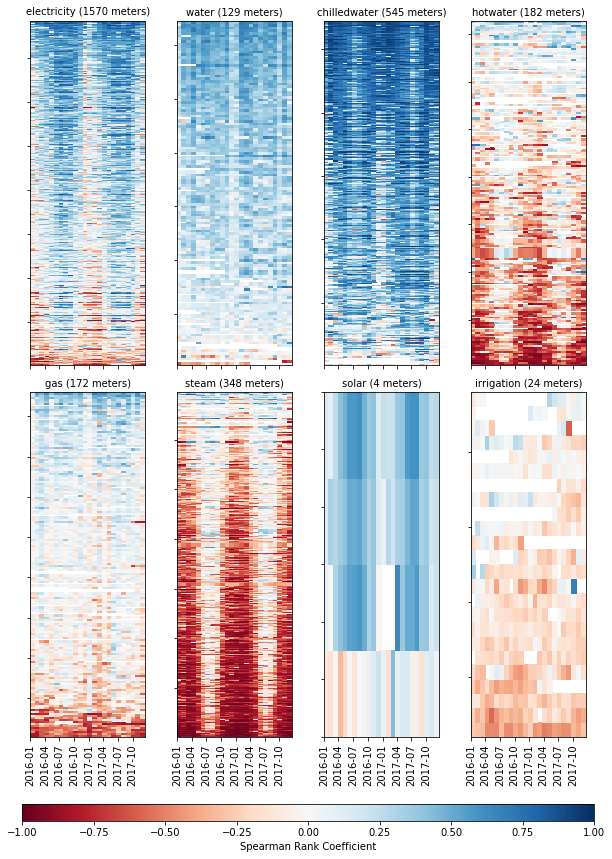

In [9]:
fig, axes = plt.subplots(2, 4, sharex = True, figsize=(8.27,11.69))
axes = axes.flatten()
numberofplots = 1

metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i,j in enumerate(metername):
    
    df = processData(j)
   
    # Get the data
    x = mdates.drange(df.columns[0], df.columns[-1] + dt.timedelta(days=30), dt.timedelta(days=30))
    y = np.linspace(1, len(df), len(df)+1)
    
    # Plot
    #ax = fig.add_subplot(numberofplots, 1, i)
    ax = axes[i]
    data = np.array(df)
    cmap = plt.get_cmap('RdBu')
    qmesh = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=True, vmin=-1, vmax=1)
    # Axis
    ax.axis('tight')
    ax.xaxis_date() # Set up as dates
    ax.tick_params("x", labelrotation=90)
    ax.set_yticklabels([])
    ax.set_title(j + " (" + str(int(max(y))) + " meters)", fontdict={'fontsize':10})

# Color bar  
cbaxes = fig.add_axes([0.025, 0.02, 0.96, 0.02]) 
cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax = cbaxes)
cbar.set_label('Spearman Rank Coefficient')

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

In [10]:
fig.savefig("..\\figures\\weatherSensitivity_all.jpg", dpi=300, bbox_inches='tight')

# Bibliography

- Miller, Clayton & Schlueter, Arno. (2015). Forensically discovering simulation feedback knowledge from a campus energy information system. 10.13140/RG.2.1.2286.0964. 